In [9]:
# Standard library imports
import math
import os
import sys
import warnings
from typing import List

# Related third-party imports
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor, 
                              RandomForestRegressor)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from tensorflow.keras.layers import Conv1D, Dense, Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

In [10]:
mlflow.set_tracking_uri("https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow")
os.environ['MLFLOW_TRACKING_USERNAME'] = 'allmamun556'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9fa2d7645d7e9f3b7d30e37916af5939cdea03c5'


In [11]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads data from a CSV file, suppresses warnings, and returns the DataFrame.

    Parameters:
    file_path (str): The path to the CSV file to be loaded.

    Returns:
    pd.DataFrame: The loaded data as a DataFrame.
    """
    
    warnings.filterwarnings('ignore')
    return pd.read_csv(file_path)

In [12]:
df = load_data('../data/Turbine_Data.csv')

print(df.columns)
df.head(5)


Index(['Unnamed: 0', 'ActivePower', 'AmbientTemperatue',
       'BearingShaftTemperature', 'Blade1PitchAngle', 'Blade2PitchAngle',
       'Blade3PitchAngle', 'ControlBoxTemperature',
       'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorRPM',
       'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature',
       'HubTemperature', 'MainBoxTemperature', 'NacellePosition',
       'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG', 'WindDirection',
       'WindSpeed'],
      dtype='object')


,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [13]:
def rename_dataframe_column(df: pd.DataFrame, old_name: str, new_name: str, inplace: bool = True) -> pd.DataFrame:
    """
    Renames a specified column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame whose column needs renaming.
    old_name (str): The current name of the column to rename.
    new_name (str): The new name for the column.
    inplace (bool): If True, renames the column in place; if False, returns a new DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with the renamed column (if inplace=False).
    """
    return df.rename(columns={old_name: new_name}, inplace=inplace) or df
df = rename_dataframe_column(df, 'Unnamed: 0', 'Time')
#print(df.head())
print(df.shape)
df.head(5) 

(118224, 22)


,Time,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [14]:
def drop_columns(df: pd.DataFrame, columns_to_drop: List[str], inplace: bool = True) -> pd.DataFrame:
    """
    Drops specified columns from a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame from which columns will be dropped.
    columns_to_drop (List[str]): A list of column names to drop from the DataFrame.
    inplace (bool): If True, drops columns in place; if False, returns a new DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with specified columns dropped (if inplace=False).
    """
    return df.drop(columns=columns_to_drop, inplace=inplace) or df

In [15]:
# Drop 'ControlBoxTemperature' and 'WTG' columns
df = drop_columns(df, ['ControlBoxTemperature', 'WTG'])
print(df.head())

                        Time  ActivePower  AmbientTemperatue  \
0  2017-12-31 00:00:00+00:00          NaN                NaN   
1  2017-12-31 00:10:00+00:00          NaN                NaN   
2  2017-12-31 00:20:00+00:00          NaN                NaN   
3  2017-12-31 00:30:00+00:00          NaN                NaN   
4  2017-12-31 00:40:00+00:00          NaN                NaN   

   BearingShaftTemperature  Blade1PitchAngle  Blade2PitchAngle  \
0                      NaN               NaN               NaN   
1                      NaN               NaN               NaN   
2                      NaN               NaN               NaN   
3                      NaN               NaN               NaN   
4                      NaN               NaN               NaN   

   Blade3PitchAngle  GearboxBearingTemperature  GearboxOilTemperature  \
0               NaN                        NaN                    NaN   
1               NaN                        NaN                    NaN   

In [16]:
missing_values = df.isnull().sum()
missing_values

Time                                0
ActivePower                     23474
AmbientTemperatue               24407
BearingShaftTemperature         55706
Blade1PitchAngle                76228
Blade2PitchAngle                76333
Blade3PitchAngle                76333
GearboxBearingTemperature       55684
GearboxOilTemperature           55786
GeneratorRPM                    55929
GeneratorWinding1Temperature    55797
GeneratorWinding2Temperature    55775
HubTemperature                  55818
MainBoxTemperature              55717
NacellePosition                 45946
ReactivePower                   23476
RotorRPM                        56097
TurbineStatus                   55316
WindDirection                   45946
WindSpeed                       23629
dtype: int64

In [17]:
df = df[df.drop(columns='Time').notna().sum(axis=1) > 0]
df

,Time,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
144,2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,-9.960830,NaN,NaN,8.000000,2.279088
145,2018-01-01 00:10:00+00:00,-5.822360,23.039754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.428571,-9.628441,NaN,NaN,300.428571,2.339343
146,2018-01-01 00:20:00+00:00,-5.279409,22.948703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,340.000000,-9.491235,NaN,NaN,340.000000,2.455610
147,2018-01-01 00:30:00+00:00,-4.648054,22.966851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,345.000000,-9.856136,NaN,NaN,345.000000,2.026754
148,2018-01-01 00:40:00+00:00,-4.684632,22.936520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,345.000000,-9.745593,NaN,NaN,345.000000,1.831420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,178.000000,13.775785,9.234004,2.0,178.000000,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,178.000000,8.088928,9.229370,2.0,178.000000,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,178.000000,4.355978,9.236802,2.0,178.000000,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,58.205413,54.079014,1030.178178,57.795387,56.847239,39.003815,36.007805,190.000000,12.018077,9.237374,2.0,190.000000,3.284468


In [18]:
# Check again the missing values
missing_values = df.isnull().sum()
missing_values

Time                                0
ActivePower                       740
AmbientTemperatue                1673
BearingShaftTemperature         32972
Blade1PitchAngle                53494
Blade2PitchAngle                53599
Blade3PitchAngle                53599
GearboxBearingTemperature       32950
GearboxOilTemperature           33052
GeneratorRPM                    33195
GeneratorWinding1Temperature    33063
GeneratorWinding2Temperature    33041
HubTemperature                  33084
MainBoxTemperature              32983
NacellePosition                 23212
ReactivePower                     742
RotorRPM                        33363
TurbineStatus                   32582
WindDirection                   23212
WindSpeed                         895
dtype: int64

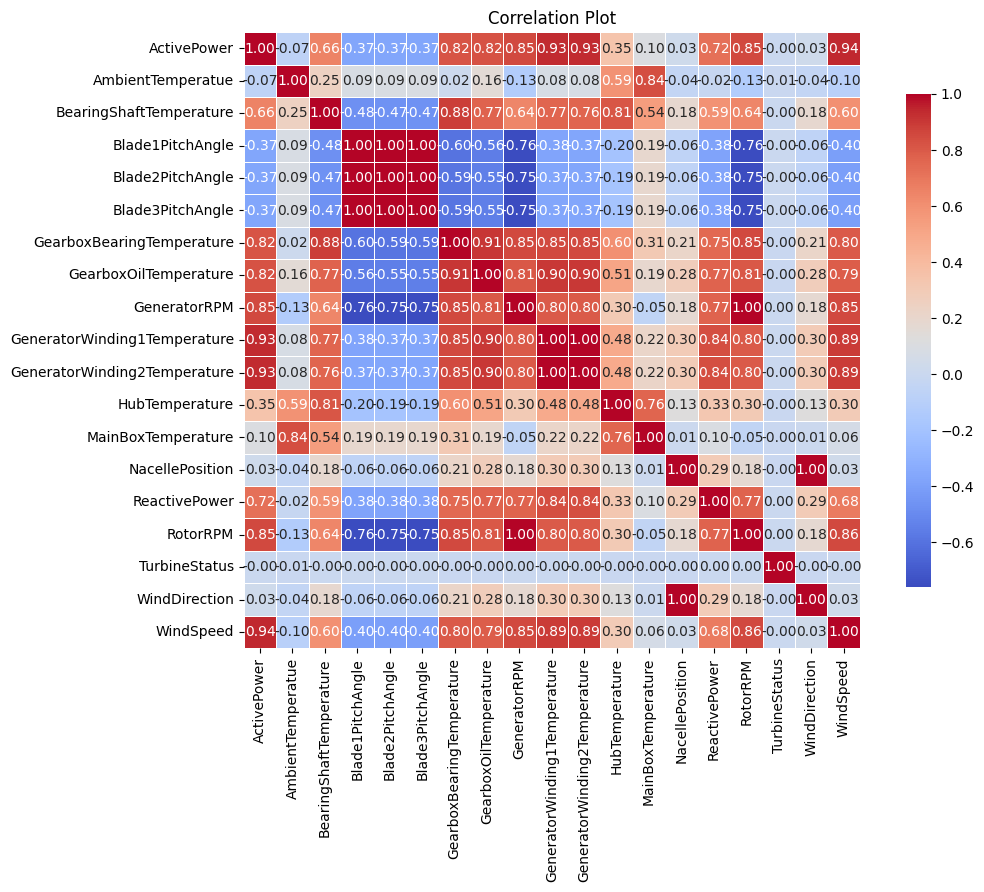

In [19]:
correlation_matrix = df.drop(columns='Time').corr()
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

plt.title('Correlation Plot')
plt.show()

In [20]:
#Removed 'GeneratorWinding2Temperature' due to high correlation with 'GeneratorWinding1Temperature
#Removed 'GearboxBearingTemperature' due to high correlation with 'GearboxOilTemperature
#Removed 'RotorRPM' due to high correlation with 'GeneratorRPM
#Removed 'Blade2PitchAngle' and 'Blade3PitchAngle' due to high correlation with 'Blade1PitchAngle
df = drop_columns(df, ['GeneratorWinding2Temperature', 'GearboxBearingTemperature','RotorRPM', \
    'Blade2PitchAngle', 'Blade3PitchAngle'])

In [21]:
print("New DataFrame Shape:", df.shape)
print("Remaining Columns:\n", df.columns)

New DataFrame Shape: (95490, 15)
Remaining Columns:
 Index(['Time', 'ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'GearboxOilTemperature', 'GeneratorRPM',
       'GeneratorWinding1Temperature', 'HubTemperature', 'MainBoxTemperature',
       'NacellePosition', 'ReactivePower', 'TurbineStatus', 'WindDirection',
       'WindSpeed'],
      dtype='object')


In [22]:
#Remaining columns after removing variables with low correlation:
correlation_matrix = df.drop(columns=['Time']).corr()
correlation_limit = 0.3 
low_correlation_vars = correlation_matrix[correlation_matrix['ActivePower'].abs() < correlation_limit].index.tolist()
if 'ActivePower' in low_correlation_vars:
    low_correlation_vars.remove('ActivePower')  

df.drop(columns=low_correlation_vars, inplace=True) 

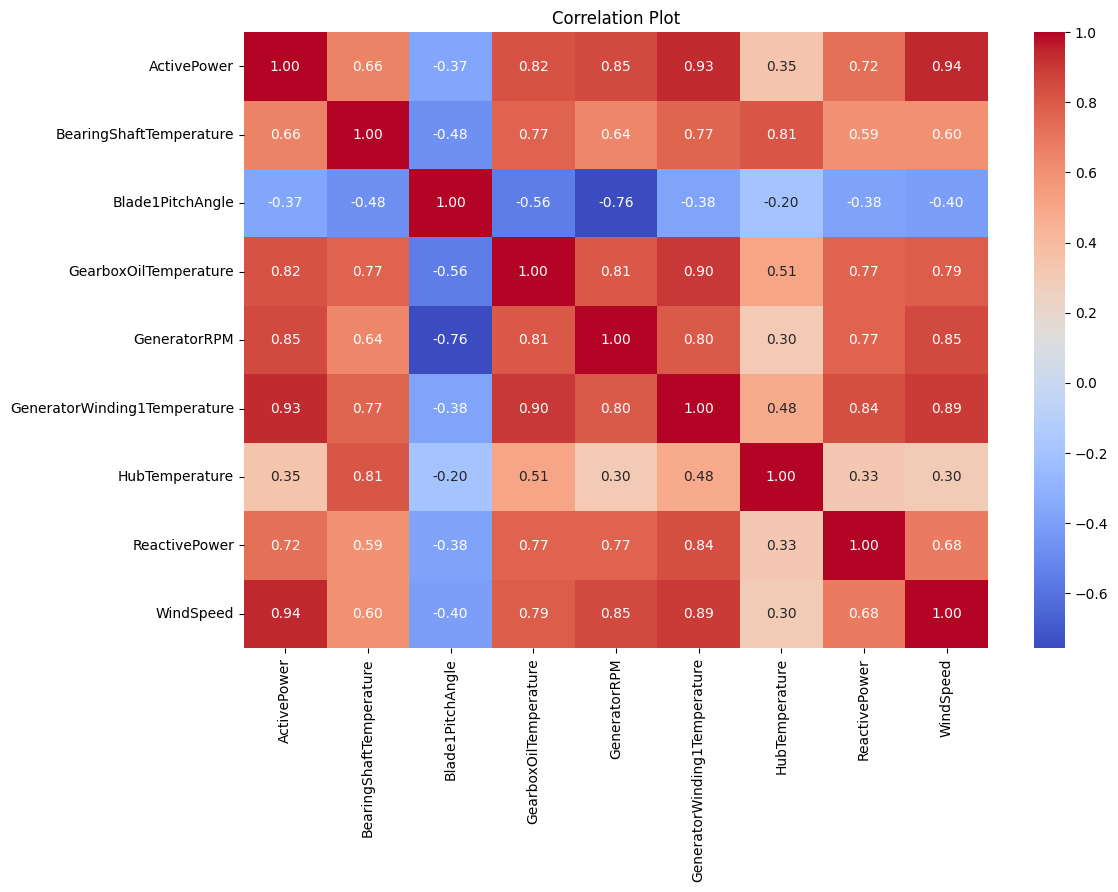

In [23]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.drop(columns=['Time']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot')
plt.show()

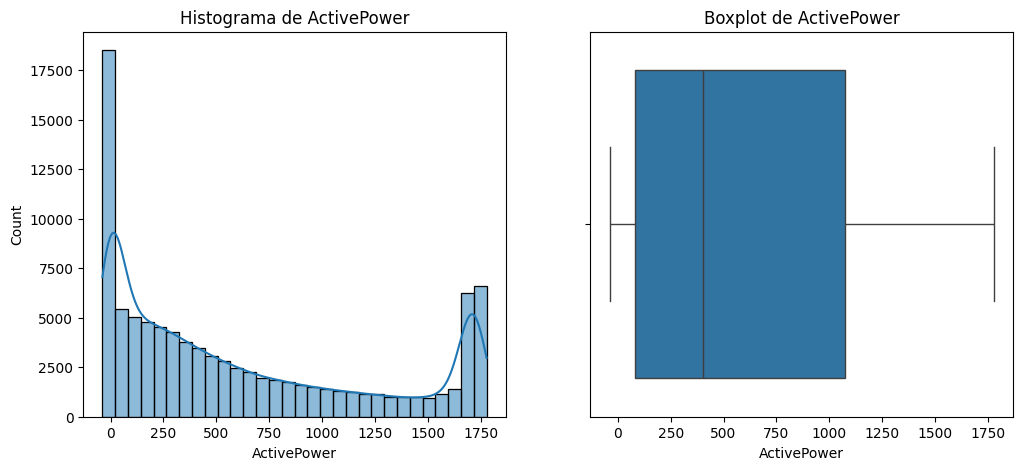

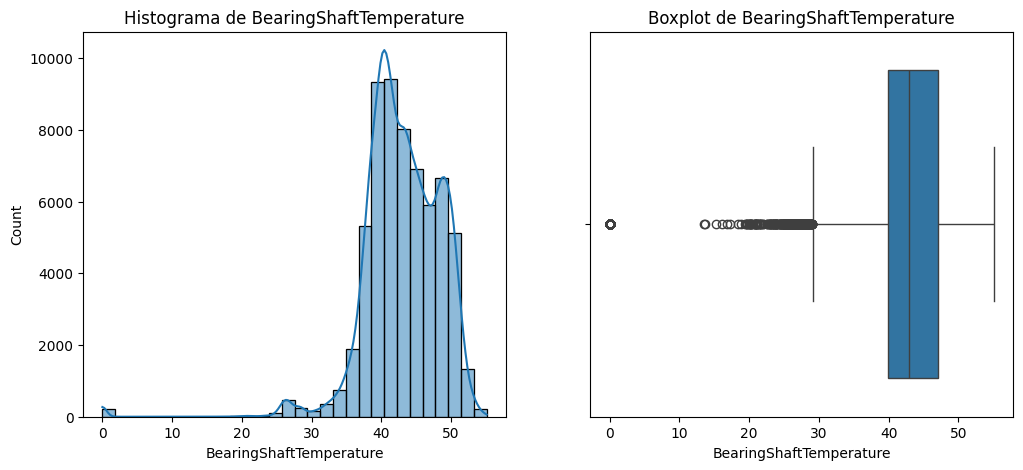

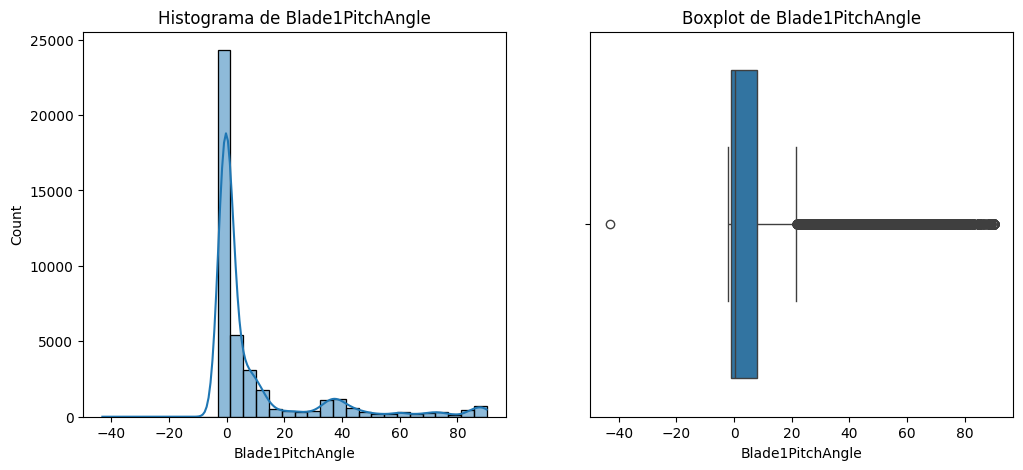

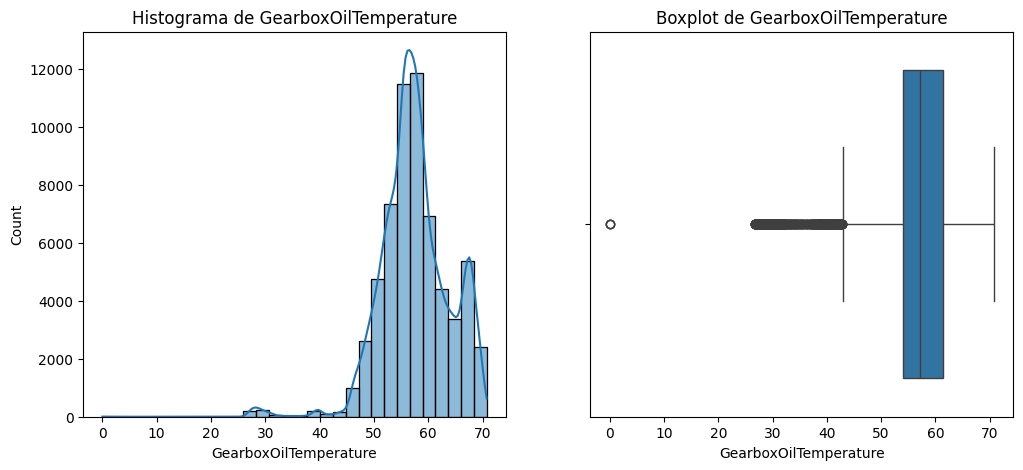

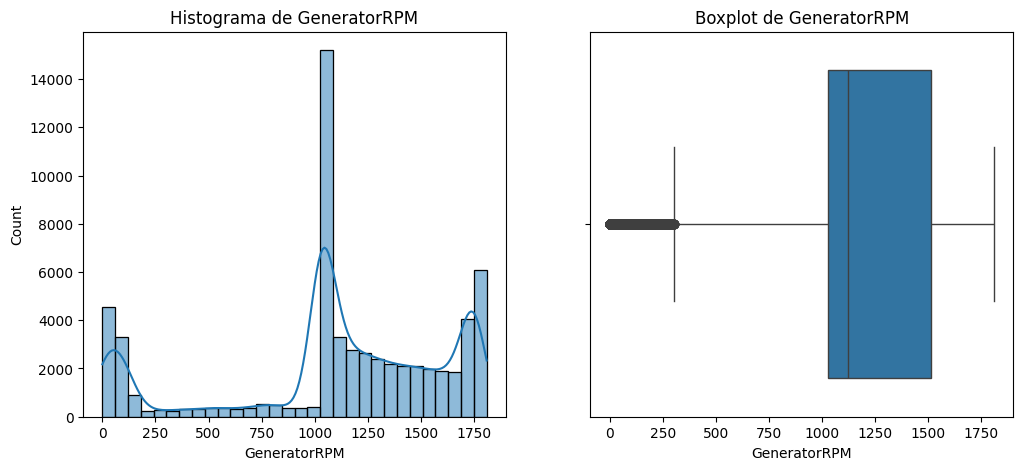

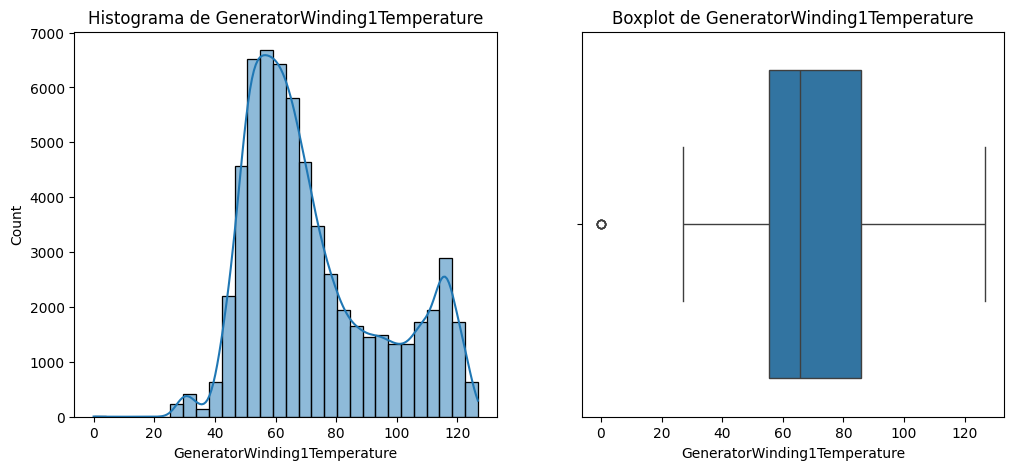

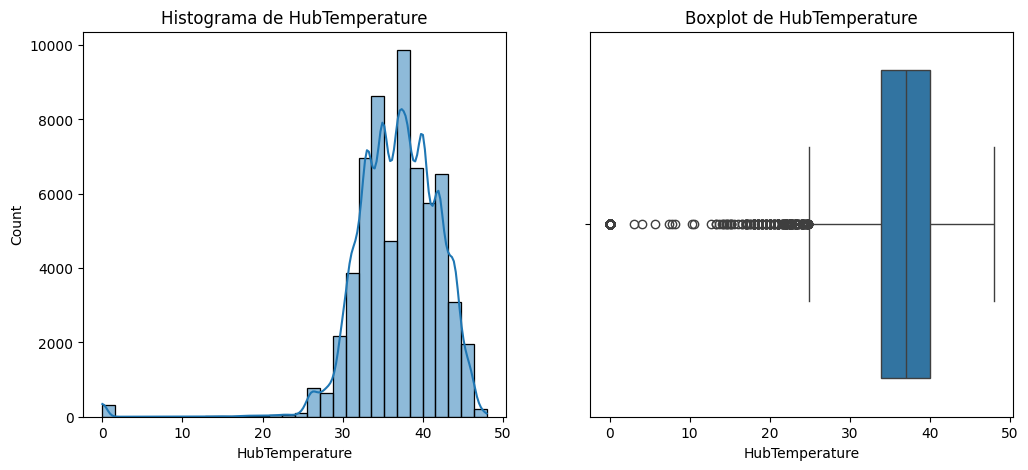

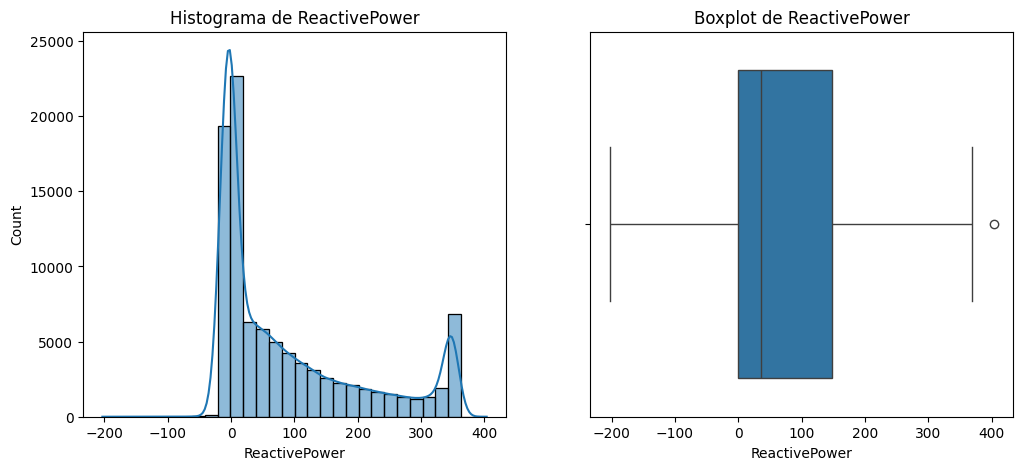

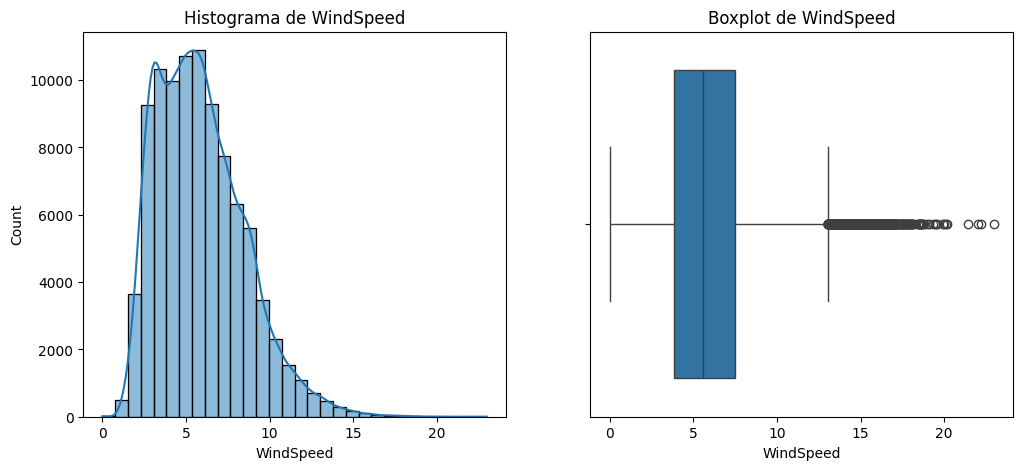

In [24]:
variables = ['ActivePower', 'BearingShaftTemperature', 'Blade1PitchAngle', 
             'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature',
             'HubTemperature', 'ReactivePower', 'WindSpeed']

for var in variables:
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[var].dropna(), bins=30, kde=True)
    plt.title(f'Histograma de {var}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot de {var}')

    plt.show()

In [25]:
stats = df[variables].describe().T[['mean', '50%', 'std']]
stats.columns = ['Mean', 'Median', 'Std Dev']
print(stats)

                                     Mean       Median     Std Dev
ActivePower                    619.109805   402.654893  611.275373
BearingShaftTemperature         43.010189    42.910877    5.545312
Blade1PitchAngle                 9.749641     0.394399   20.644828
GearboxOilTemperature           57.561217    57.196089    6.323895
GeneratorRPM                  1102.026269  1124.860720  528.063946
GeneratorWinding1Temperature    72.460403    65.788800   22.627489
HubTemperature                  36.897978    37.003815    5.178711
ReactivePower                   88.133966    35.883659  116.596725
WindSpeed                        5.878960     5.557765    2.619084


In [26]:
for var in variables:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    print(f'Outliers em {var}:')
    print(outliers)

Outliers em ActivePower:
Empty DataFrame
Columns: [Time, ActivePower, BearingShaftTemperature, Blade1PitchAngle, GearboxOilTemperature, GeneratorRPM, GeneratorWinding1Temperature, HubTemperature, ReactivePower, WindSpeed]
Index: []
Outliers em BearingShaftTemperature:
                             Time  ActivePower  BearingShaftTemperature  \
33158   2018-08-18 06:20:00+00:00     0.000000                 0.000000   
33207   2018-08-18 14:30:00+00:00  1691.912000                23.745117   
33211   2018-08-18 15:10:00+00:00  1709.615500                 0.000000   
33340   2018-08-19 12:40:00+00:00  1722.106275                24.032682   
33355   2018-08-19 15:10:00+00:00          NaN                 0.000000   
...                           ...          ...                      ...   
102390  2019-12-12 01:00:00+00:00   175.322860                27.399008   
102391  2019-12-12 01:10:00+00:00   154.224601                27.933973   
102392  2019-12-12 01:20:00+00:00   177.847757          

In [27]:
df['ActivePower'].fillna(df['ActivePower'].interpolate(method='linear'), inplace=True)


df['BearingShaftTemperature'].fillna(df['BearingShaftTemperature'].median(), inplace=True)

df['Blade1PitchAngle'].fillna(df['Blade1PitchAngle'].median(), inplace=True)


df['GearboxOilTemperature'].fillna(df['GearboxOilTemperature'].median(), inplace=True)

df['GeneratorRPM'].fillna(df['GeneratorRPM'].median(), inplace=True)

df['GeneratorWinding1Temperature'].fillna(df['GeneratorWinding1Temperature'].median(), inplace=True)


df['HubTemperature'].fillna(df['HubTemperature'].median(), inplace=True)


df['ReactivePower'].fillna(df['ReactivePower'].median(), inplace=True)

df['WindSpeed'].fillna(df['WindSpeed'].median(), inplace=True)


missing_values = df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 Time                            0
ActivePower                     0
BearingShaftTemperature         0
Blade1PitchAngle                0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
HubTemperature                  0
ReactivePower                   0
WindSpeed                       0
dtype: int64


In [28]:
# Checking for Stationarity

# Augmented Dickey-Fuller (ADF) Test
result = adfuller(df['ActivePower'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

#KPSS Test
kpss_statistic, p_value, _, critical_values = kpss(df['ActivePower'])
print('KPSS Statistic:', kpss_statistic)
print('p-value:', p_value)
print('Critical Values:', critical_values)



ADF Statistic: -17.676695931658447
p-value: 3.6239019820187515e-30
KPSS Statistic: 1.3741621620554274
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


ADF Statistic (Differenced): -52.68325737759488
p-value (Differenced): 0.0
KPSS Statistic (Differenced): 0.0042131672312233645
p-value (Differenced): 0.1


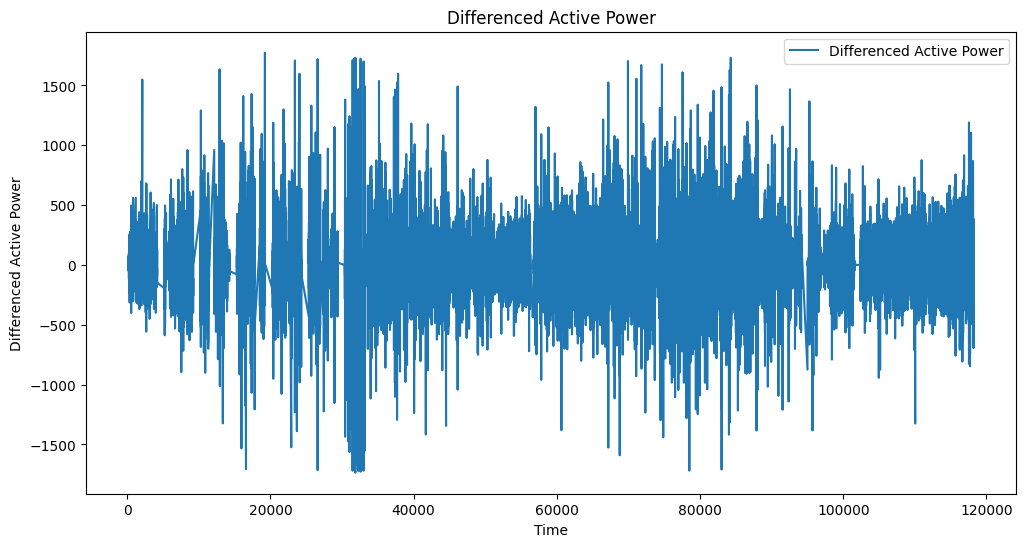

In [29]:
# Applying differentiation to the 'ActivePower' column

df['active_power_diff'] = df['ActivePower'].diff().dropna()

# Performing the ADF (Augmented Dickey-Fuller) test on the differenced series
# The ADF test checks for stationarity in the time series data.
result_adf = adfuller(df['active_power_diff'].dropna())

# Printing the ADF statistic and p-value for the differenced series

print('ADF Statistic (Differenced):', result_adf[0])
print('p-value (Differenced):', result_adf[1])

# Performing the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test on the differenced series
# The KPSS test also checks for stationarity but has the null hypothesis that the series is stationary.
kpss_statistic, p_value, _, critical_values = kpss(df['active_power_diff'].dropna())

# Printing the KPSS statistic and p-value for the differenced series

print('KPSS Statistic (Differenced):', kpss_statistic)
print('p-value (Differenced):', p_value)

plt.figure(figsize=(12, 6))
# Plotting the differenced active power data
plt.plot(df['active_power_diff'], label='Differenced Active Power')
plt.title('Differenced Active Power')
plt.xlabel('Time')
plt.ylabel('Differenced Active Power')
plt.legend()
plt.show()

In [30]:
# **a) Fitting the ARIMA model**
data= df
df['active_power_diff'].fillna(df['active_power_diff'].mean(), inplace=True)

model_arima = ARIMA(df['active_power_diff'].dropna(), order=(1, 1, 2))
model_arima_fit = model_arima.fit()

# **b) Fitting the Exponential Smoothing model**
model_exp = ExponentialSmoothing(df['active_power_diff'].dropna(), trend='add', seasonal='add', seasonal_periods=12)
model_exp_fit = model_exp.fit()

# **c) Preparing data for other models**
df.to_csv('deepnn.csv')

X = df.drop(columns=['ActivePower', 'Time'])
y = df['ActivePower']

# Removing NaNs
X = X.dropna()
y = y.loc[X.index]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **d) Fitting the Random Forest model**
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# **e) Fitting the Decision Tree model**
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

# **f) Fitting the AdaBoost model**
model_ada = AdaBoostRegressor(n_estimators=100)
model_ada.fit(X_train, y_train)
y_pred_ada = model_ada.predict(X_test)

# **g) Fitting the Gradient Boosting model**
model_gb = GradientBoostingRegressor(n_estimators=100)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

# **i) Fitting the ANN model**
model_ann = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
model_ann.fit(X_train, y_train)
y_pred_ann = model_ann.predict(X_test)

# **m) Fitting the Polynomial Regression model**
poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_poly_train, y_train)
y_pred_poly = model_poly.predict(X_poly_test)

# **n) Fitting the Linear Regression model**
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# **o) Making predictions for ARIMA and Exponential Smoothing**
y_pred_arima = model_arima_fit.forecast(steps=len(y_test))
y_pred_exp = model_exp_fit.forecast(steps=len(y_test))

# **RNN, LSTM, CNN Models - with scaled and sequential data preparation**

# Load your dataset and fill missing values in 'active_power_diff'
#df_cleaned = data.drop(columns=['Unnamed: 0'])
df['active_power_diff'].fillna(df['active_power_diff'].mean(), inplace=True)

# Dropping 'Time' column
df = df.drop(columns=['Time'])

# Define the target and features
X = df.drop(columns=['ActivePower'])
y = df['ActivePower']

# Normalize the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Define the sequence length (timesteps)
sequence_length = 10
X_seq, y_seq = [], []

# Creating sequences for model input
for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq = np.array(X_seq, dtype=np.float64)
y_seq = np.array(y_seq, dtype=np.float64)

# Train-test split for sequential models
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

# **r) Fitting the RNN model**
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
history_rnn = model_rnn.fit(X_train_seq, y_train_seq, epochs=2, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# Predict using RNN
y_pred_rnn = model_rnn.predict(X_test_seq)
y_pred_actual_rnn = scaler_y.inverse_transform(y_pred_rnn)
y_test_actual_rnn = scaler_y.inverse_transform(y_test_seq)

# **s) Fitting the LSTM model**
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=2, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# Predict using LSTM
y_pred_lstm = model_lstm.predict(X_test_seq)
y_pred_actual_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_test_actual_lstm = scaler_y.inverse_transform(y_test_seq)

# **t) Fitting the CNN model**
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.compile(optimizer='adam', loss='mean_squared_error')
history_cnn = model_cnn.fit(X_train_seq, y_train_seq, epochs=2, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# Predict using CNN
y_pred_cnn = model_cnn.predict(X_test_seq)
y_pred_actual_cnn = scaler_y.inverse_transform(y_pred_cnn)
y_test_actual_cnn = scaler_y.inverse_transform(y_test_seq)

# **p) Evaluation - Calculating RMSE for each model**

# RMSE for ARIMA and Exponential Smoothing
rmse_arima = mean_squared_error(y_test, y_pred_arima, squared=False)
rmse_exp = mean_squared_error(y_test, y_pred_exp, squared=False)

# RMSE for other models
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
rmse_ada = mean_squared_error(y_test, y_pred_ada, squared=False)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
rmse_ann = mean_squared_error(y_test, y_pred_ann, squared=False)
rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

# RMSE for RNN, LSTM, CNN
mse_rnn = mean_squared_error(y_test_actual_rnn, y_pred_actual_rnn)
mae_rnn = mean_absolute_error(y_test_actual_rnn, y_pred_actual_rnn)
r2_rnn = r2_score(y_test_actual_rnn, y_pred_actual_rnn)

mse_lstm = mean_squared_error(y_test_actual_lstm, y_pred_actual_lstm)
mae_lstm = mean_absolute_error(y_test_actual_lstm, y_pred_actual_lstm)
r2_lstm = r2_score(y_test_actual_lstm, y_pred_actual_lstm)

mse_cnn = mean_squared_error(y_test_actual_cnn, y_pred_actual_cnn)
mae_cnn = mean_absolute_error(y_test_actual_cnn, y_pred_actual_cnn)
r2_cnn = r2_score(y_test_actual_cnn, y_pred_actual_cnn)

Epoch 1/2
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0219 - val_loss: 0.0073
Epoch 2/2
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0100 - val_loss: 0.0072
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/2
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0304 - val_loss: 0.0067
Epoch 2/2
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0099 - val_loss: 0.0075
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/2
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0244 - val_loss: 0.0065
Epoch 2/2
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0098 - val_loss: 0.0060
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step


In [31]:
import pickle
filename = 'random_forest_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_rf, file)

print(f"Model saved as {filename}")

Model saved as random_forest_model.pkl


In [32]:
# Check feature names during training
print("Features during training:", model_rf.feature_names_in_)

# Check feature names during prediction

Features during training: ['BearingShaftTemperature' 'Blade1PitchAngle' 'GearboxOilTemperature'
 'GeneratorRPM' 'GeneratorWinding1Temperature' 'HubTemperature'
 'ReactivePower' 'WindSpeed' 'active_power_diff']


## Model Evaluation <a name="model-evaluation"></a>
After building our models, we will evaluate their performance using various metrics. We will compare the predictions against the actual outcomes to determine how well our models are performing.

In [33]:
# Function to calculate and log error metrics and parameters
def evaluate_model_with_mlflow(y_true, y_pred, model_name, params):
    mae = mean_absolute_error(y_true, y_pred)  # Calculate Mean Absolute Error
    mse = mean_squared_error(y_true, y_pred)   # Calculate Mean Squared Error
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Calculate Root Mean Squared Error
    r2 = r2_score(y_true, y_pred)              # Calculate R² Score

    print(f"{model_name} Performance:")        # Print the model name
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}\n")  # Print the metrics

     # Write the metrics to a text file
    with open("metrics.txt", "a") as f:
        f.write(f"{model_name} Performance:\n")
        f.write(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}\n")
        f.write("-" * 30 + "\n")

    # Start MLflow run
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)
        # Log metrics
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)

# Example of logging for each model:

# 1. Logging for ARIMA model
arima_params = {'p': 3, 'd': 1, 'q': 0}  # Replace these with your actual ARIMA params
evaluate_model_with_mlflow(y_test, y_pred_arima, "ARIMA", arima_params)

# 2. Logging for Exponential Smoothing model
exp_params = {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}  # Replace with your actual params
evaluate_model_with_mlflow(y_test, y_pred_exp, "Exponential Smoothing", exp_params)

# 3. Logging for Random Forest model
rf_params = {'n_estimators': 100, 'max_depth': 10}  # Replace with your actual RF params
evaluate_model_with_mlflow(y_test, y_pred_rf, "Random Forest", rf_params)

# 1. Logging for Decision Tree model
dt_params = {}  # No specific hyperparameters provided in the example
evaluate_model_with_mlflow(y_test, y_pred_dt, "Decision Tree", dt_params)

# 2. Logging for AdaBoost model
ada_params = {'n_estimators': 100}
evaluate_model_with_mlflow(y_test, y_pred_ada, "AdaBoost", ada_params)

# 3. Logging for Gradient Boosting model
gb_params = {'n_estimators': 100}
evaluate_model_with_mlflow(y_test, y_pred_gb, "Gradient Boosting", gb_params)

# 9. Logging for Polynomial Regression model
poly_params = {'degree': 3}
evaluate_model_with_mlflow(y_test, y_pred_poly, "Polynomial Regression", poly_params)

# 10. Logging for Linear Regression model
lr_params = {}  # No specific hyperparameters for Linear Regression
evaluate_model_with_mlflow(y_test, y_pred_lr, "Linear Regression", lr_params)

# 4. Logging for CNN model
cnn_params = {'filters': 64, 'kernel_size': 2}  # Replace these with the actual CNN parameters
evaluate_model_with_mlflow(y_test_actual_cnn, y_pred_actual_cnn, "CNN", cnn_params)

# 5. Logging for ANN model
ann_params = {'hidden_layer_sizes': (100, 50), 'max_iter': 500}  # Replace these with the actual ANN parameters
evaluate_model_with_mlflow(y_test, y_pred_ann, "ANN", ann_params)

# 6. Logging for RNN model
rnn_params = {'layers': 50, 'activation': 'relu'}  # Replace these with the actual RNN parameters
evaluate_model_with_mlflow(y_test_actual_rnn, y_pred_actual_rnn, "RNN", rnn_params)

# 7. Logging for LSTM model
lstm_params = {'layers': 50, 'activation': 'relu'}  # Replace these with the actual LSTM parameters
evaluate_model_with_mlflow(y_test_actual_lstm, y_pred_actual_lstm, "LSTM", lstm_params)




ARIMA Performance:
MAE: 2494049.6083, MSE: 6237479808260.7197, RMSE: 2497494.7064, R²: -16614884.2229



2024/11/04 17:33:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run ARIMA at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/a7ed6826fa314bacbeb462149c6ed17f.
2024/11/04 17:33:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


Exponential Smoothing Performance:
MAE: 715.3508, MSE: 889531.1722, RMSE: 943.1496, R²: -1.3695



2024/11/04 17:33:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Exponential Smoothing at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/d9208693a3c84d7e92465e46dd6afa81.
2024/11/04 17:33:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


Random Forest Performance:
MAE: 13.9113, MSE: 2536.4252, RMSE: 50.3629, R²: 0.9932



2024/11/04 17:33:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/6b18b9d512614af4977113d24ef03648.
2024/11/04 17:33:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


Decision Tree Performance:
MAE: 18.2632, MSE: 4149.3578, RMSE: 64.4155, R²: 0.9889



2024/11/04 17:33:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run Decision Tree at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/3a83d3cc9ff948108d42f937891e407d.
2024/11/04 17:33:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


AdaBoost Performance:
MAE: 78.3105, MSE: 12843.9653, RMSE: 113.3312, R²: 0.9658



2024/11/04 17:33:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run AdaBoost at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/e273fdf77c4a4805924c24ec1d130731.
2024/11/04 17:33:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


Gradient Boosting Performance:
MAE: 34.6990, MSE: 4740.3086, RMSE: 68.8499, R²: 0.9874



2024/11/04 17:33:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient Boosting at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/ed4083af3e684b888d2af97219292b06.
2024/11/04 17:33:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


Polynomial Regression Performance:
MAE: 49.9762, MSE: 16340.8416, RMSE: 127.8313, R²: 0.9565



2024/11/04 17:33:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Polynomial Regression at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/960526393db24d8ba4d6575e1c1d29ae.
2024/11/04 17:33:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


Linear Regression Performance:
MAE: 137.3145, MSE: 40624.9321, RMSE: 201.5563, R²: 0.8918



2024/11/04 17:33:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Linear Regression at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/83c5f909b9b346499912b63f6d71b5ea.
2024/11/04 17:33:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


CNN Performance:
MAE: 95.6057, MSE: 19966.1495, RMSE: 141.3016, R²: 0.9097



2024/11/04 17:33:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run CNN at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/310b9f3a2e234882971bebf200e7d632.
2024/11/04 17:33:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


ANN Performance:
MAE: 19.9308, MSE: 3362.0510, RMSE: 57.9832, R²: 0.9910



2024/11/04 17:34:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run ANN at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/3e727270f4b44443be82de612203b9dd.
2024/11/04 17:34:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


RNN Performance:
MAE: 115.2098, MSE: 23666.8951, RMSE: 153.8405, R²: 0.8930



2024/11/04 17:34:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run RNN at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/1b9d62f8546a4fc9831e6ad501d01a61.
2024/11/04 17:34:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.


LSTM Performance:
MAE: 112.8387, MSE: 24698.7579, RMSE: 157.1584, R²: 0.8883



2024/11/04 17:34:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTM at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0/runs/9516b9d42ff24b0d9e68f194c2c33bc1.
2024/11/04 17:34:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/allmamun556/MLOPS_CI_CD_MONITORING.mlflow/#/experiments/0.
